In [1]:
path_full_summarized_table = "../datasets/2023-01-01_benchmark_processed_data/2023-01-27_FullTableAurocFiltered.tsv"
path_config_viz = "../config/visualization.yaml"
path_output_dir = "./tmp"
export_plots = False


# Forewords

Exploration of the differences in performance of models using sequence only as an input feature
and models using both sequence and structure.


Steps : 
- for each method + dataset + negative set: rank the auROCs.
- for each dataset + negative set: calculate the average rank per model
- plot the avg_rank_seq vs avg_rank_seq+struct ; spot those which show large deviation.
- check how these behave in the difference of auroc between neg1 and neg2.

# Imports and definitions

/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


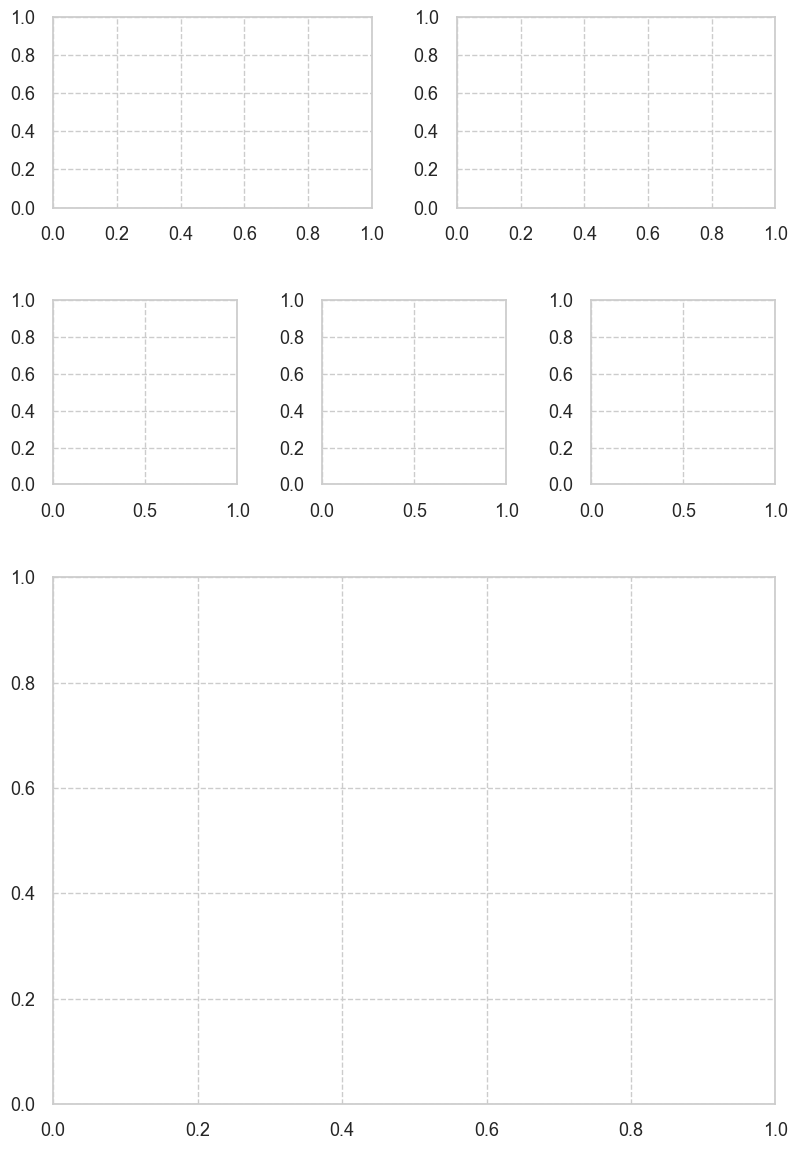

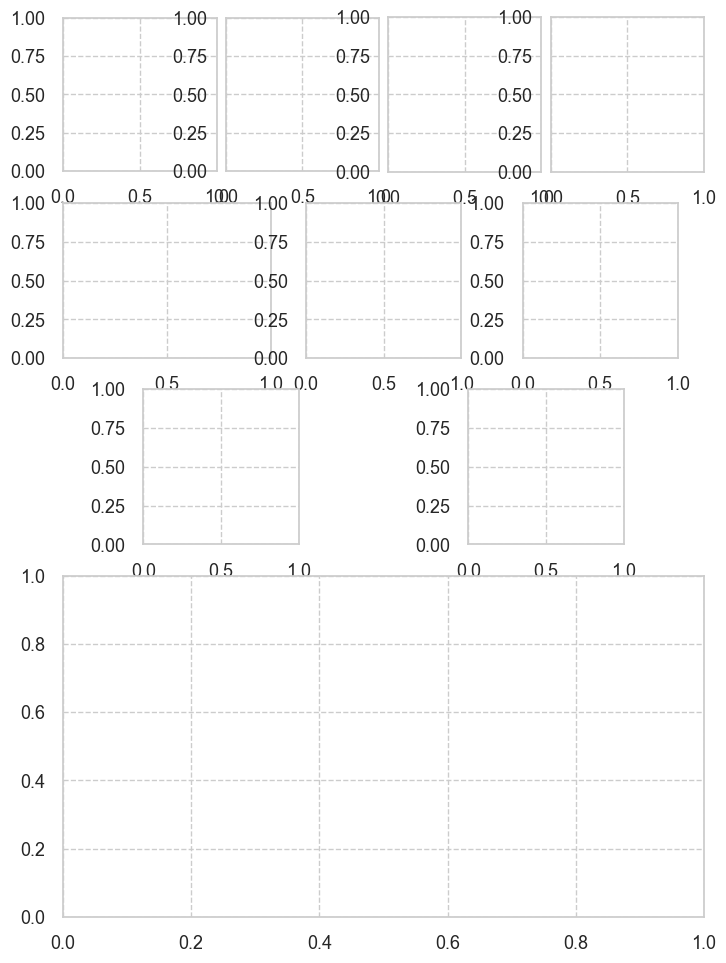

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

# Load 

## Data 

In [3]:
full_summarized_table = pd.read_csv(
    path_full_summarized_table, sep="\t", header=0, index_col=None
)


## Config

In [4]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


In [5]:
DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


In [14]:
sequence_only = [
    "Pysster-101",  # Pysster-101 is closer to the perf of other methods; using it should remove the input-length favorable bias.
    "DeepCLIP",
    "DeepRAM",
    # BERT-RBP, # Excluded given the poor results.
]
sequence_structure = ["PRISMNet", "iDeepS"]

map_method_to_inputfeat = {
    **{k: "seq" for k in sequence_only},
    **{k: "seq+struct" for k in sequence_structure},
}


# Prepare and explore tables

## Prepare

In [15]:
def get_data_prismnet():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "PRISMNet",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        0.9
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        0.9
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [16]:
def get_data_ideeps():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "iDeepS",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        0.9
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        0.9
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [17]:
ideeps_tmp_inputfeat_n1_piv_ALT, ideeps_tmp_inputfeat_n2_piv_ALT = get_data_ideeps()
(
    prismnet_tmp_inputfeat_n1_piv_ALT,
    prismnet_tmp_inputfeat_n2_piv_ALT,
) = get_data_prismnet()


## Explore 

### Number of models, models with largest delta auROCs

In [18]:
print(
    ideeps_tmp_inputfeat_n1_piv_ALT.shape[0], prismnet_tmp_inputfeat_n1_piv_ALT.shape[0]
)


302 302


In [19]:
ideeps_rbps = set(
    ideeps_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps = set(
    prismnet_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)


In [20]:
print(len(prismnet_rbps))
print(len(ideeps_rbps))


31
31


In [21]:
print(
    (
        "Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)\n "
        "found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :"
        f"{len(prismnet_rbps & ideeps_rbps)}"
    )
)


Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)
 found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :13


For paper: selected "EWSR1", "PUS1", "CAPRIN1".

In [22]:
display(prismnet_rbps & ideeps_rbps)


{'ABCF1_K562',
 'AKAP1_K562',
 'Ago2_UNKNOWN_HITSCLIP_4',
 'CAPRIN1_HEK293_PARCLIP',
 'CPEB4_K562',
 'DICER1_HEK293_PARCLIP',
 'EWSR1_HEK293_PARCLIP',
 'G45_HEK293_PARCLIP',
 'PUS1_K562',
 'QKI_HEK293_PARCLIP',
 'SUPV3L1_K562',
 'UPF1_HEK293_PARCLIP',
 'ZC3H11A_K562'}

In [23]:
prismnet_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
180,ENCODE,SUPV3L1_K562,0.754856,0.890727,0.135871,True
6,ENCODE,AKAP1_K562,0.769056,0.889051,0.119996,True
2,ENCODE,ABCF1_K562,0.816998,0.922625,0.105627,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.735108,0.834146,0.099038,True
217,ENCODE,ZC3H11A_K562,0.757359,0.847297,0.089938,True
137,ENCODE,PUS1_K562,0.702508,0.792128,0.089620,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.780200,0.867643,0.087442,True
16,ENCODE,CPEB4_K562,0.764860,0.851189,0.086329,True
260,Mukherjee-PAR-CLIP,QKI_HEK293_PARCLIP,0.881496,0.964527,0.083031,True
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.831268,0.911033,0.079764,True


In [24]:
ideeps_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.831268,0.951273,0.120004,True
260,Mukherjee-PAR-CLIP,QKI_HEK293_PARCLIP,0.881496,0.983722,0.102227,True
226,Mukherjee-PAR-CLIP,CAPRIN1_HEK293_PARCLIP,0.768848,0.868386,0.099538,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.780200,0.847299,0.067098,True
275,iONMF,Ago2_UNKNOWN_HITSCLIP_4,0.816784,0.880279,0.063495,True
268,Mukherjee-PAR-CLIP,UPF1_HEK293_PARCLIP,0.815025,0.878368,0.063343,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.735108,0.794396,0.059288,True
137,ENCODE,PUS1_K562,0.702508,0.761681,0.059173,True
16,ENCODE,CPEB4_K562,0.764860,0.820679,0.055819,True
180,ENCODE,SUPV3L1_K562,0.754856,0.809689,0.054833,True


## Plots

### iDeepS

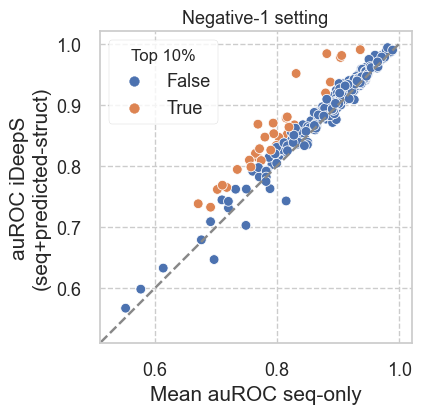

In [25]:
panel_name = "m"
# savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
savefig_file = None

fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=ideeps_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


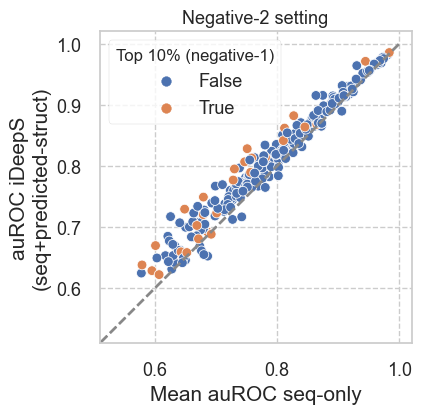

In [26]:
panel_name = "n"
# savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=ideeps_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")
ax1.legend_.set_title("Top 10% (negative-1)")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
ax1.set_aspect("equal")
ax1.set_aspect("equal")
ax1.set_xlim(0.51, 1.02)
ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)
fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


### PrismNet

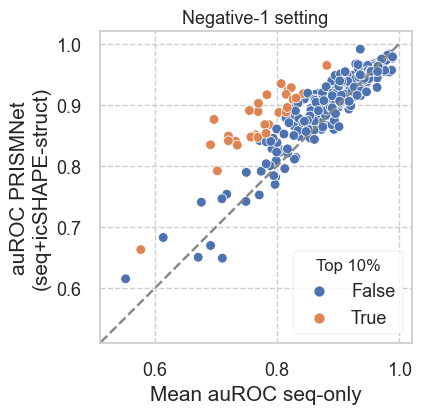

In [27]:
panel_name = "o"
# savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
savefig_file = None

fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=prismnet_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


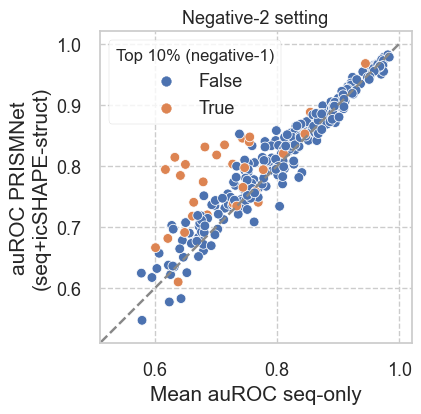

In [28]:
# PRISMNET
panel_name = "p"
# savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=prismnet_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()
